In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Import

In [2]:
import pandas
import numexpr
import numpy
from rep_ef.estimators import MatrixNetSkyGridClassifier
from rep.metaml import FoldingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
def statistics(data):
    print 'Events:', len(numpy.unique(data.event)), 'vrt:', len(data)

## Reading initial data

In [4]:
data = pandas.read_csv('../../datasets/Tagging/Vertices.csv', sep='\t')

## Define label
`label` = `signB` * `signVtx`
* the highest output means that this is same sign B as vtx (right tagged) - label 1
* the lowest output means that this is opposite sign B than vtx (wrong tagged) - label 0

In [5]:
data['label'] = (data.signB.values * data.signVtx.values > 0) * 1

In [6]:
# import root_numpy
# data2 = pandas.DataFrame(root_numpy.root2array('datasets/nnet_vtx.root'))

In [7]:
data.head()

,run,event,No,mult,nnkrec,Bmass,ptB,vflag,ptmean,ipsmean,...,svm,svp,BDphiDir,svtau,docamax,signB,signVtx,N_sig_sw,v_cut,label
0,115839,490856995,0,19,3,5.27051,0.682494,5,0.612396,2.82952,...,8.090450,234.8170,-1.014500,0.848175,0.011098,-1,-1,1.034010,0,1
1,115839,822264706,0,10,2,5.28157,8.309650,2,0.438413,4.65750,...,0.483020,20.8185,0.390429,4.783480,0.000000,-1,1,1.091840,0,0
2,115839,831865829,0,50,6,5.21344,1.150550,2,0.560779,5.98035,...,1.332900,33.1151,-0.039351,0.837979,0.000000,-1,-1,-0.442372,0,1
3,115839,835954815,0,21,2,5.27418,5.809860,2,0.574965,15.80120,...,0.508337,32.2970,0.013839,9.961430,0.000000,1,1,1.071050,0,1
4,115839,68238381,0,16,4,5.23794,2.200840,5,0.818976,4.17709,...,6.816220,88.1742,-1.098810,1.092720,0.009995,-1,1,-0.263734,0,0


In [8]:
statistics(data)

Events: 609984 vrt: 610050


In [9]:
N_all = 742632.88650423975 

In [10]:
N_pass = sum([gr['N_sig_sw'].values[0] for _, gr in data.groupby('event')])
eff_tag = 1. * N_pass / N_all
eff_delta = sqrt(N_pass) / N_all
eff_tag, eff_delta

(0.56906249670983988, 0.00087537248932607946)

In [11]:
data = data[data.v_cut == 1]

In [12]:
N_pass = sum([gr['N_sig_sw'].values[0] for _, gr in data.groupby('event')])
eff_tag = 1. * N_pass / N_all
eff_delta = sqrt(N_pass) / N_all
eff_tag, eff_delta

(0.15351747151663503, 0.00045466530576336611)

### define B-like events for training and others for prediction

In [13]:
sweight_threshold = 1.
data_sw_pass = data[data.N_sig_sw > sweight_threshold]
data_sw_not_pass = data[data.N_sig_sw <= sweight_threshold]
statistics(data_sw_pass)

Events: 96215 vrt: 96215


# Find good vtx to define sign B

### Define features

In [14]:
features = list(set(data.columns) - {'run', 'event', 'No', 'signB', 'signVtx', 'N_sig_sw', 'Bmass', 'mult', 
                                     'PIDNNp', 'PIDNNpi', 'label'})
features

['vflag',
 'svm',
 'BDphiDir',
 'vcharge',
 'svp',
 'v_cut',
 'docamax',
 'ptB',
 'svtau',
 'ptmean',
 'nnkrec',
 'ipsmean']

### 2-folding random forest selection for right tagged events

In [27]:
base = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=50, n_jobs=8)
est_choose_RT = FoldingClassifier(base, features=features, random_state=13)
est_choose_RT.fit(data_sw_pass, data_sw_pass.label, data_sw_pass.N_sig_sw)

FoldingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         features=['vflag', 'svm', 'BDphiDir', 'vcharge', 'svp', 'v_cut', 'docamax', 'ptB', 'svtau', 'ptmean', 'nnkrec', 'ipsmean'],
         ipc_profile=None, n_folds=2, random_state=13)

### AUC

In [28]:
probs_RT = union(est_choose_RT.predict_proba(data_sw_pass)[:, 1], 
                 est_choose_RT.predict_proba(data_sw_not_pass)[:, 1])
roc_auc_score(union(data_sw_pass.label.values, data_sw_not_pass.label.values), 
              probs_RT, sample_weight=union(data_sw_pass.N_sig_sw.values, data_sw_not_pass.N_sig_sw.values))

KFold prediction using folds column
KFold prediction using folds column


0.54169090301211009

### ROC

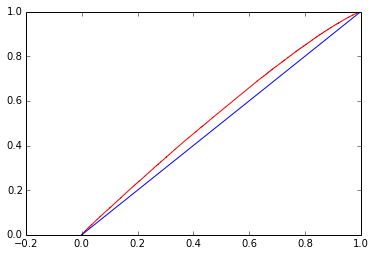

In [29]:
fpr, tpr, _ = roc_curve(union(data_sw_pass.label.values, data_sw_not_pass.label.values), 
                        probs_RT, sample_weight=union(data_sw_pass.N_sig_sw.values, data_sw_not_pass.N_sig_sw.values))
plot(fpr, tpr)
plot([0, 1], [0, 1])

In [30]:
imp = numpy.sum([est.feature_importances_ for est in est_choose_RT.estimators], axis=0)
pandas.DataFrame({'importance': -sort(-imp) / max(imp), 
                  'feature': numpy.array(est_choose_RT.features)[numpy.argsort(-imp)]})

,feature,importance
0,vcharge,1.000000
1,ptmean,0.458956
2,svm,0.443141
3,ipsmean,0.342626
4,BDphiDir,0.304951
5,svp,0.299507
6,svtau,0.289744
7,ptB,0.258782
8,docamax,0.239560
9,vflag,0.124884


## Distributions for output

KFold prediction using folds column


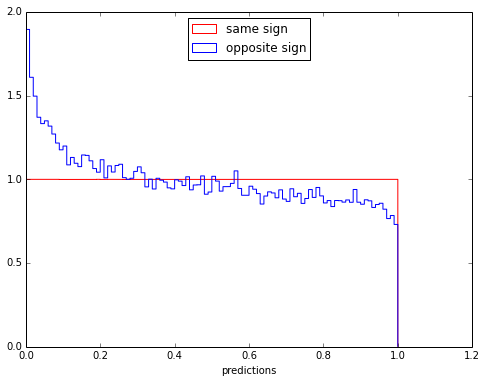

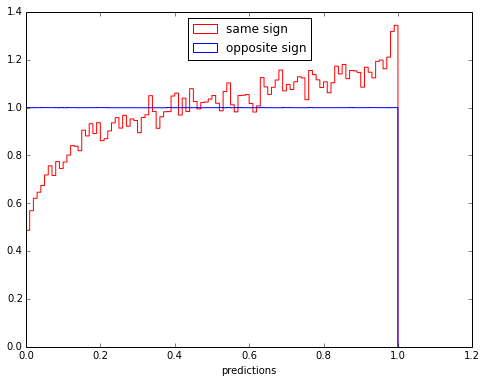

In [155]:
probs = est_choose_RT.predict_proba(data_sw_pass)
flat_ss = run_flat_probs(probs, data_sw_pass.label.values, data_sw_pass.N_sig_sw.values, label=1)
flat_os = run_flat_probs(probs, data_sw_pass.label.values, data_sw_pass.N_sig_sw.values, label=0)

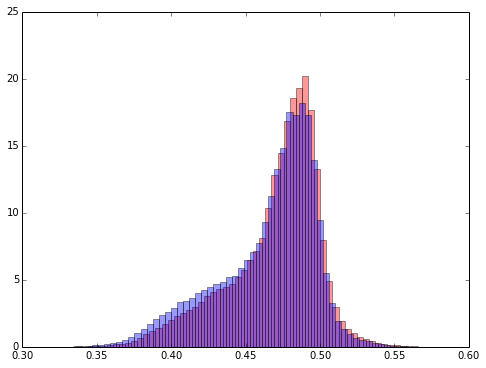

In [35]:
hist(probs[data_sw_pass.label.values == 1][:, 1], bins=60, normed=True, alpha=0.4)
hist(probs[data_sw_pass.label.values == 0][:, 1], bins=60, normed=True, alpha=0.4)
pass

## Select good svr

In [37]:
mask = ((flat_ss_probs < 2.) & (data_sw_pass.label == 0)) | ((flat_os_probs > 0.6) & (data_sw_pass.label == 1))
data_sw_pass_selected = data_sw_pass[mask]
data_sw_pass_not_selected = data_sw_pass[~mask]

In [38]:
statistics(data_sw_pass_selected)

Events: 262758 vrt: 262772


In [39]:
from rep_ef.estimators import MatrixNetSkyGridClassifier
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=3000, regularization=0.02, sync=False)
mn_folding_rf = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                                  features=features)
mn_folding_rf.fit(data_sw_pass_selected, data_sw_pass_selected.label, data_sw_pass_selected.N_sig_sw)

FoldingClassifier(base_estimator=MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=3000, max_features_per_iteration=6,
              regularization=0.02, sync=False, train_features=None,
              training_fraction=0.5, user_name='antares'),
         features=['vflag', 'svm', 'BDphiDir', 'vcharge', 'svp', 'v_cut', 'docamax', 'ptB', 'svtau', 'ptmean', 'nnkrec', 'ipsmean'],
         ipc_profile=None, n_folds=2, random_state=11)

In [50]:
probs_RT = union(mn_folding_rf.predict_proba(data_sw_pass_selected)[:, 1], 
                 mn_folding_rf.predict_proba(data_sw_pass_not_selected)[:, 1], 
                 mn_folding_rf.predict_proba(data_sw_not_pass)[:, 1])
roc_auc_score(union(data_sw_pass_selected.label.values, 
                    data_sw_pass_not_selected.label.values, data_sw_not_pass.label.values), 
              probs_RT, 
              sample_weight=union(data_sw_pass_selected.N_sig_sw.values, 
                                  data_sw_pass_not_selected.N_sig_sw.values, data_sw_not_pass.N_sig_sw.values))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


0.5429533013340021

-----------

### MN full

In [30]:
from rep_ef.estimators import MatrixNetSkyGridClassifier
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=3000, regularization=0.02, sync=False)

mn_folding = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                               features=features)
mn_folding.fit(data_sw_pass, data_sw_pass.label, data_sw_pass.N_sig_sw)

FoldingClassifier(base_estimator=MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=3000, max_features_per_iteration=6,
              regularization=0.02, sync=False, train_features=None,
              training_fraction=0.5, user_name='antares'),
         features=['vflag', 'svm', 'BDphiDir', 'vcharge', 'svp', 'v_cut', 'docamax', 'ptB', 'svtau', 'ptmean', 'nnkrec', 'ipsmean'],
         ipc_profile=None, n_folds=2, random_state=11)

In [31]:
probs_RT = union(mn_folding.predict_proba(data_sw_pass)[:, 1], 
                 mn_folding.predict_proba(data_sw_not_pass)[:, 1])
roc_auc_score(union(data_sw_pass.label.values, data_sw_not_pass.label.values), 
              probs_RT, sample_weight=union(data_sw_pass.N_sig_sw.values, data_sw_not_pass.N_sig_sw.values))

KFold prediction using folds column
KFold prediction using folds column


0.54321131989709026

### XGB full

In [16]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(colsample=1.0, eta=0.01, nthreads=4, 
                             n_estimators=500, subsample=0.3, max_depth=3) 
xgb_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11, 
                                features=features)
xgb_folding.fit(data_sw_pass, data_sw_pass.label, data_sw_pass.N_sig_sw)

FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=1.0, eta=0.01, features=None,
         gamma=None, max_depth=3, min_child_weight=1.0, missing=-999.0,
         n_estimators=500, nthreads=4, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.3, verbose=0),
         features=['vflag', 'svm', 'BDphiDir', 'vcharge', 'svp', 'v_cut', 'docamax', 'ptB', 'svtau', 'ptmean', 'nnkrec', 'ipsmean'],
         ipc_profile=None, n_folds=2, random_state=11)

In [17]:
probs_RT = union(xgb_folding.predict_proba(data_sw_pass)[:, 1], 
                 xgb_folding.predict_proba(data_sw_not_pass)[:, 1])
roc_auc_score(union(data_sw_pass.label.values, data_sw_not_pass.label.values), 
              probs_RT, sample_weight=union(data_sw_pass.N_sig_sw.values, data_sw_not_pass.N_sig_sw.values))

KFold prediction using folds column
KFold prediction using folds column


0.54637150290616021

In [117]:
# from rep.utils import train_test_split_group
# data_train, data_test_gl, flat_ss_probs, _ , flat_os_probs, _, labels_train, labels_test_gl = \
#                                                                 train_test_split_group(data['event'],
#                                                                                     data, flat_ss_probs,
#                                                                                     flat_os_probs, product_sign,
#                                                                                     random_state=11, train_size=0.5)

--------

## Isotonic calibration to probabity p(vrt same sign|B)

In [ ]:
%run 

### MN + rf selection

In [167]:
temp_p0 = est_choose_RT.predict_proba(data_sw_pass_selected)[:, 1]
temp_p1 = est_choose_RT.predict_proba(data_sw_pass_not_selected)[:, 1]
temp_p2 = est_choose_RT.predict_proba(data_sw_not_pass)[:, 1]

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


In [ ]:
data_sw_not_pass['tag'] = (flat_os(temp_p2) > 0.6) | (flat_ss(temp_p2) < 0.4)
data_sw_pass_not_selected['tag'] = (flat_os(temp_p1) > 0.6) | (flat_ss(temp_p1) < 0.4)
data_sw_pass_selected['tag'] = (flat_os(temp_p0) > 0.6) | (flat_ss(temp_p0) < 0.4)

In [168]:
D2, alpha, aucs, iso_calibs = calibration(mn_folding_rf, 
                                          [data_sw_pass_selected, data_sw_pass_not_selected, data_sw_not_pass], 
                                          steps=30)

/mnt/mfs/ipython_env/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  if __name__ == '__main__':
/mnt/mfs/ipython_env/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  from IPython.kernel.zmq import kernelapp as app


KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


/mnt/mfs/ipython_env/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  app.launch_new_instance()


In [169]:
print 'AUC', numpy.mean(aucs), numpy.var(aucs)

AUC 0.550513131156 0.0


In [170]:
N_pass_rf = sum([gr['N_sig_sw'].values[0] for _, gr in data_sw_not_pass[data_sw_not_pass.tag].groupby('event')])
N_pass_rf += sum([gr['N_sig_sw'].values[0] for _, gr in data_sw_pass_selected.groupby('event')])
result_table(1. * N_pass_rf / N_all, sqrt(N_pass_rf) / N_all, D2)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
0,42.926919,0.076029,0.006674,0,0.286473,0.000507


### MN

In [32]:
D2, alpha, aucs, iso_calibs = calibration(mn_folding, 
                                          [data_sw_pass, data_sw_not_pass], 
                                          steps=30)

KFold prediction using folds column
KFold prediction using folds column


In [33]:
print 'AUC', numpy.mean(aucs), numpy.var(aucs)

AUC 0.539747998236 0.0


In [34]:
result_table(eff_tag, eff_delta, D2)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
0,15.351747,0.045467,0.012955,0,0.198886,0.000589


### XGB

In [20]:
data_sw_pass['tag'] = True
data_sw_not_pass['tag'] = True

In [21]:
D2, alpha, aucs, iso_calibs = calibration(xgb_folding, 
                                          [data_sw_pass, data_sw_not_pass], 
                                          steps=30)

KFold prediction using folds column
KFold prediction using folds column


In [22]:
print 'AUC', numpy.mean(aucs), numpy.var(aucs)54.6 54.75

AUC 0.547375400874 0.0


In [23]:
result_table(eff_tag, eff_delta, D2) 0.218

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
0,15.351747,0.045467,0.011292,0,0.173348,0.000513


------------

In [91]:
temp_probs = mn_folding_rf.predict_proba(data_sw_not_pass)[:, 1], mn_folding_rf.predict_proba(data_sw_pass_not_selected)[:, 1], mn_folding_rf.predict_proba(data_sw_pass_selected)[:, 1]

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


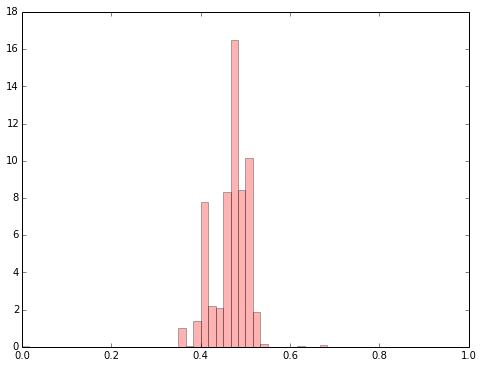

In [94]:
hist(iso_calibs[0].transform(temp_probs[0]), bins=60, alpha=0.3, label='not passed', normed=True)
pass

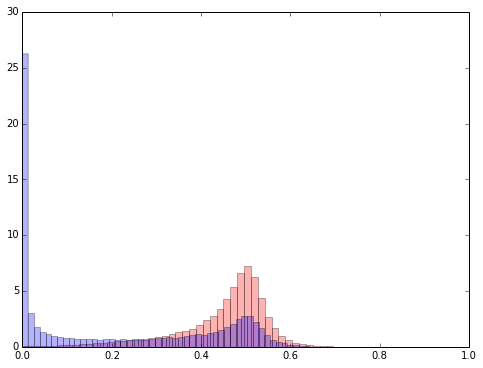

In [106]:
hist(temp_probs[2][data_sw_pass_selected.label.values == 1], bins=60, alpha=0.3, label='not passed', normed=True)
hist(temp_probs[2][data_sw_pass_selected.label.values == 0], bins=60, alpha=0.3, label='not passed', normed=True)


pass

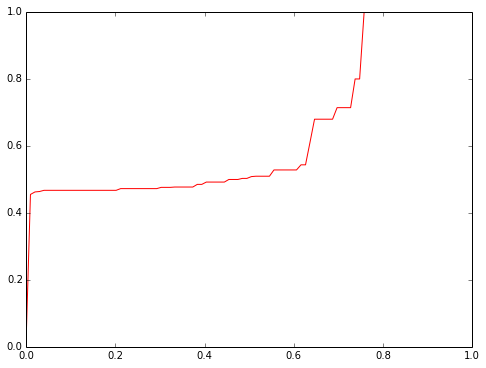

In [95]:
x = numpy.linspace(0, 1, 100)
plot(x, iso_calibs[0].transform(x))

In [ ]:
hist(temp_probs[1], bins=60, alpha=0.3, label='not selected (ss)', normed=True)
hist(temp_probs[2], bins=60, alpha=0.3, label='selected', normed=True)
legend()
pass